# ROAD ACCIDENTS SURVIVAL PRIDICTION

**Introduction**

Road accidents represent a significant public health concern worldwide. Understanding the factors that influence survival outcomes can help inform safety policies, vehicle design improvements, and emergency response protocols.

This analysis explores the Road Accident Survival Dataset to identify key demographic, behavioral, and situational factors that impact the probability of surviving a road accident. Our goal is to build a predictive model that accurately estimates survival probability based on these factors and extract actionable insights to improve road safety.

We will focus on the relationship between age, gender, speed of impact, safety device usage, and survival outcomes, creating both descriptive insights and predictive models.

**Importing Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
import xgboost as XGBoost
import warnings
warnings.filterwarnings('ignore')


In [5]:
#pip install xgboost

In [6]:
# Set visualization style
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

**Uploadint the dataset**

In [7]:
Rodf = pd.read_csv('accident.csv')

In [9]:
Rodf.head()

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


Our dataset contains 200 records with 6 features including both numerical variables (Age, Speed_of_Impact) and categorical variables (Gender, Helmet_Used, Seatbelt_Used) along with our target variable (Survived).

First, we'll check for missing values and handle them appropriately:

In [15]:
Rodf.shape

(200, 6)

In [16]:
# 200 rows and 6 columns

In [18]:
# missing values

Rodf.isnull().sum()

Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64

In [19]:
# missing value in Gender and Speed_of_impact

In [21]:
# Handle missing values
# For Gender, fill with the most common value
Rodf['Gender'].fillna(Rodf['Gender'].mode()[0], inplace=True)

Rodf['Speed_of_Impact'].fillna(Rodf['Speed_of_Impact'].median(), inplace=True)



In [22]:
# Basic statistics
print("\nBasic statistics of numerical features:")
Rodf.describe().round(2)


Basic statistics of numerical features:


,Age,Speed_of_Impact,Survived
count,200.00,200.00,200.0
mean,43.42,70.45,0.5
std,14.94,29.90,0.5
min,18.00,20.00,0.0
25%,31.00,43.00,0.0
50%,43.50,71.00,1.0
75%,56.00,95.00,1.0
max,69.00,119.00,1.0


**Data Visualizaion and Feature Analysis**

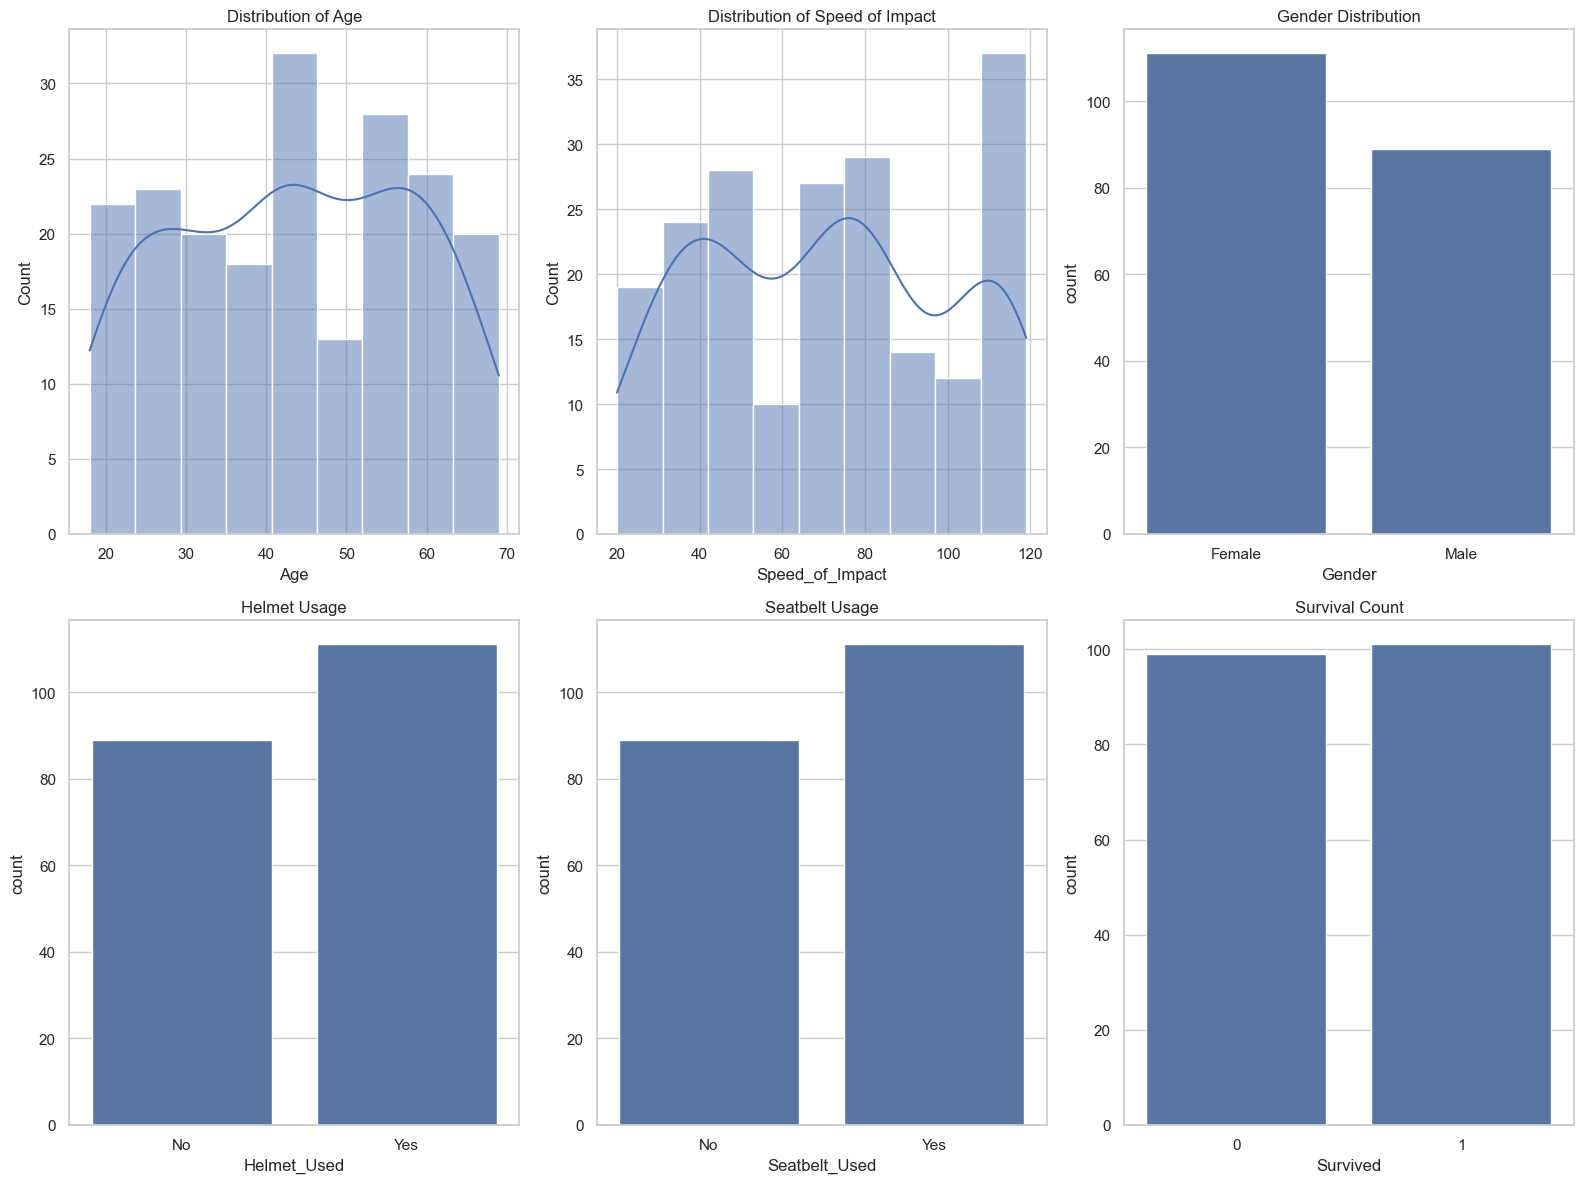

In [24]:
# Create visualizations of key variables
plt.figure(figsize=(16, 12))

# Distribution of Age
plt.subplot(2, 3, 1)
sns.histplot(Rodf['Age'], kde=True)
plt.title('Distribution of Age')

# Distribution of Speed of Impact
plt.subplot(2, 3, 2)
sns.histplot(Rodf['Speed_of_Impact'], kde=True)
plt.title('Distribution of Speed of Impact')

# Gender distribution
plt.subplot(2, 3, 3)
sns.countplot(x='Gender', data=Rodf)
plt.title('Gender Distribution')

# Helmet Usage
plt.subplot(2, 3, 4)
sns.countplot(x='Helmet_Used', data=Rodf)
plt.title('Helmet Usage')

# Seatbelt Usage
plt.subplot(2, 3, 5)
sns.countplot(x='Seatbelt_Used', data=Rodf)
plt.title('Seatbelt Usage')

# Survival Count
plt.subplot(2, 3, 6)
sns.countplot(x='Survived', data=Rodf)
plt.title('Survival Count')

plt.tight_layout()
plt.show()

In [25]:
# let's examine how different factors relate to survival outcomes:

In [26]:
# Create age groups and speed groups for better analysis
Rodf['Age_Group'] = pd.cut(Rodf['Age'], bins=[0, 30, 45, 60, 100], labels=['<30', '30-45', '45-60', '>60'])
Rodf['Speed_Group'] = pd.cut(Rodf['Speed_of_Impact'], bins=[0, 40, 80, 120], labels=['Low', 'Medium', 'High'])

# Create visualizations of relationships with survival
plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

Text(0, 0.5, 'Survival Rate')

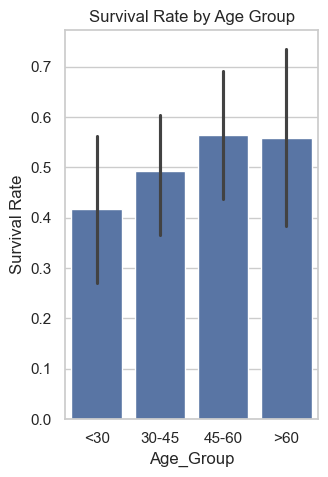

In [27]:
# Survival rate by age group
plt.subplot(1, 2, 1)
sns.barplot(x='Age_Group', y='Survived', data=Rodf, estimator=np.mean)
plt.title('Survival Rate by Age Group')
plt.ylabel('Survival Rate')

Text(0, 0.5, 'Survival Rate')

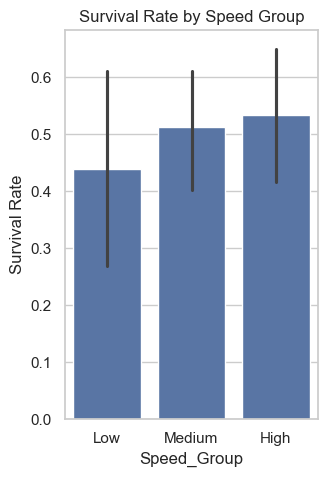

In [28]:
# Survival rate by speed group
plt.subplot(1, 2, 2)
sns.barplot(x='Speed_Group', y='Survived', data=Rodf, estimator=np.mean)
plt.title('Survival Rate by Speed Group')
plt.ylabel('Survival Rate')

Text(0, 0.5, 'Survival Rate')

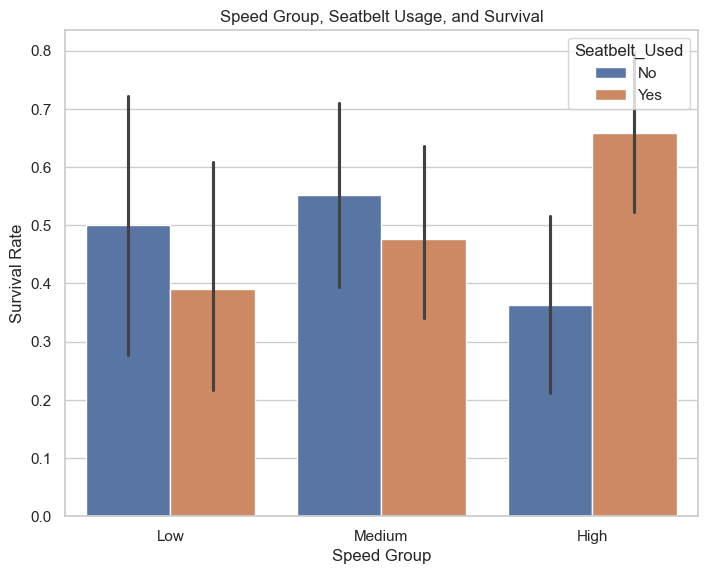

In [29]:
# Explore safety equipment effectiveness
plt.figure(figsize=(16, 6))

# Interaction between Speed Group, Seatbelt Usage, and Survival
plt.subplot(1, 2, 1)
sns.barplot(x='Speed_Group', y='Survived', hue='Seatbelt_Used', data=Rodf)
plt.title('Speed Group, Seatbelt Usage, and Survival')
plt.xlabel('Speed Group')
plt.ylabel('Survival Rate')

Text(0, 0.5, 'Survival Rate')

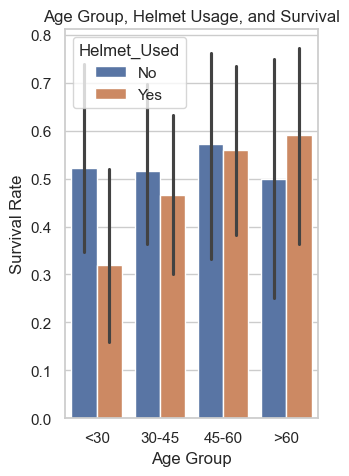

In [30]:
# Interaction between Age Group, Helmet Usage, and Survival
plt.subplot(1, 2, 2)
sns.barplot(x='Age_Group', y='Survived', hue='Helmet_Used', data=Rodf)
plt.title('Age Group, Helmet Usage, and Survival')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')

In [31]:
# Based on our exploratory analysis, we'll create new features that might better capture the relationships we've observed:

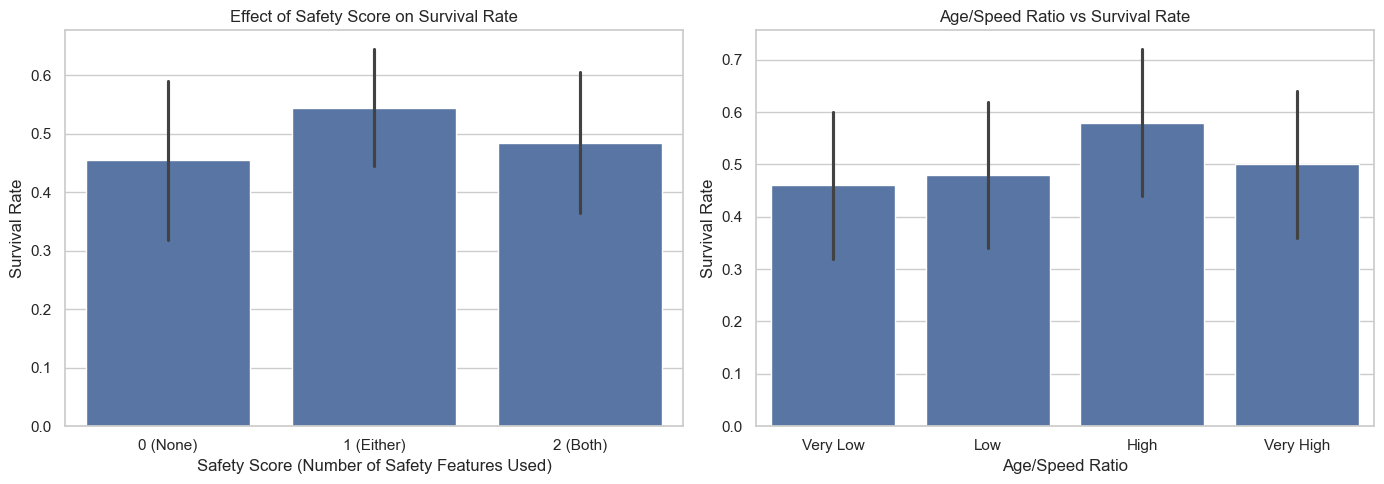

In [32]:
# Create new interaction features
# Combine Age and Speed
Rodf['Age_Speed_Ratio'] = Rodf['Age'] / Rodf['Speed_of_Impact']

# Create safety score (0, 1, or 2 safety features used)
Rodf['Safety_Score'] = (Rodf['Helmet_Used'] == 'Yes').astype(int) + (Rodf['Seatbelt_Used'] == 'Yes').astype(int)

# Let's visualize the effect of these new features
plt.figure(figsize=(14, 5))

# Effect of safety score on survival
plt.subplot(1, 2, 1)
sns.barplot(x='Safety_Score', y='Survived', data=Rodf)
plt.title('Effect of Safety Score on Survival Rate')
plt.xlabel('Safety Score (Number of Safety Features Used)')
plt.ylabel('Survival Rate')
plt.xticks([0, 1, 2], ['0 (None)', '1 (Either)', '2 (Both)'])

# Relationship between Age/Speed Ratio and Survival
plt.subplot(1, 2, 2)
# Create bins for the Age/Speed Ratio
Rodf['Age_Speed_Ratio_Bin'] = pd.qcut(Rodf['Age_Speed_Ratio'], 4, labels=['Very Low', 'Low', 'High', 'Very High'])
sns.barplot(x='Age_Speed_Ratio_Bin', y='Survived', data=Rodf)
plt.title('Age/Speed Ratio vs Survival Rate')
plt.xlabel('Age/Speed Ratio')
plt.ylabel('Survival Rate')

plt.tight_layout()
plt.show()


**Data Preparation for Modeling**

In [33]:
# Prepare data for modeling
# One-hot encode categorical variables
df_model = pd.get_dummies(Rodf, columns=['Gender', 'Helmet_Used', 'Seatbelt_Used'], drop_first=True)

# Define features and target
X = df_model[['Age', 'Speed_of_Impact', 'Gender_Male', 'Helmet_Used_Yes', 
              'Seatbelt_Used_Yes', 'Age_Speed_Ratio', 'Safety_Score']]
y = df_model['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
# We'll build and compare several classification models to find the most effective approach:

Logistic Regression - Accuracy: 0.6167, AUC: 0.6195
Random Forest - Accuracy: 0.4333, AUC: 0.4590
Gradient Boosting - Accuracy: 0.5000, AUC: 0.5561
XGBoost - Accuracy: 0.4833, AUC: 0.5679


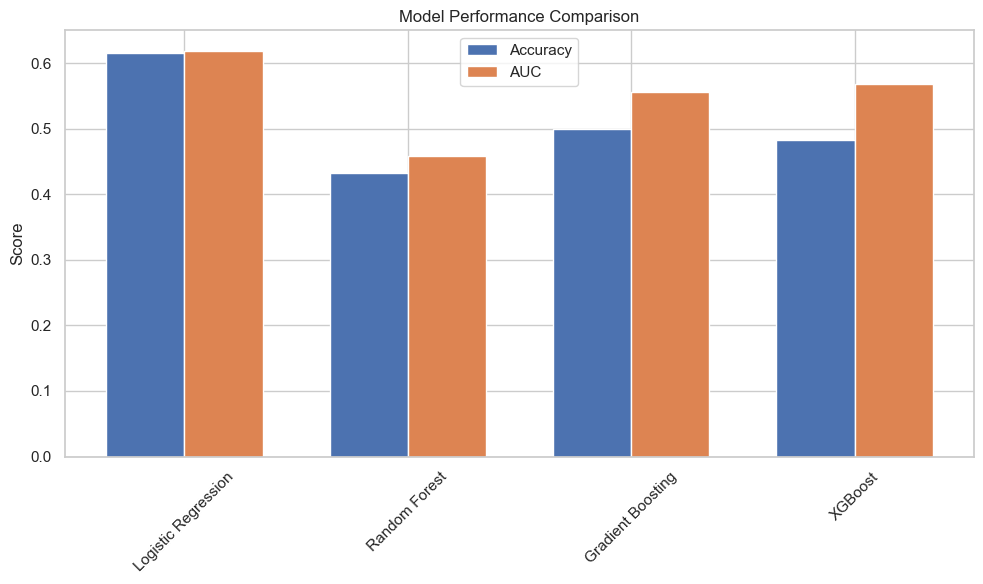

In [35]:
# Build multiple models for comparison
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBoost.XGBClassifier(random_state=42)
}

# Fit all models and collect results
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and AUC
    accuracy = accuracy_score(y_test, y_pred)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'model': model
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

# Visualize model performance
plt.figure(figsize=(10, 6))
accuracies = [results[name]['accuracy'] for name in models.keys()]
aucs = [results[name]['auc'] for name in models.keys()]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, aucs, width, label='AUC')
plt.xticks(x, models.keys(), rotation=45)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()

**Model Optimization**

Our initial comparison shows that Logistic Regression performs best on this dataset. Let's optimize it through hyperparameter tuning and feature selection:

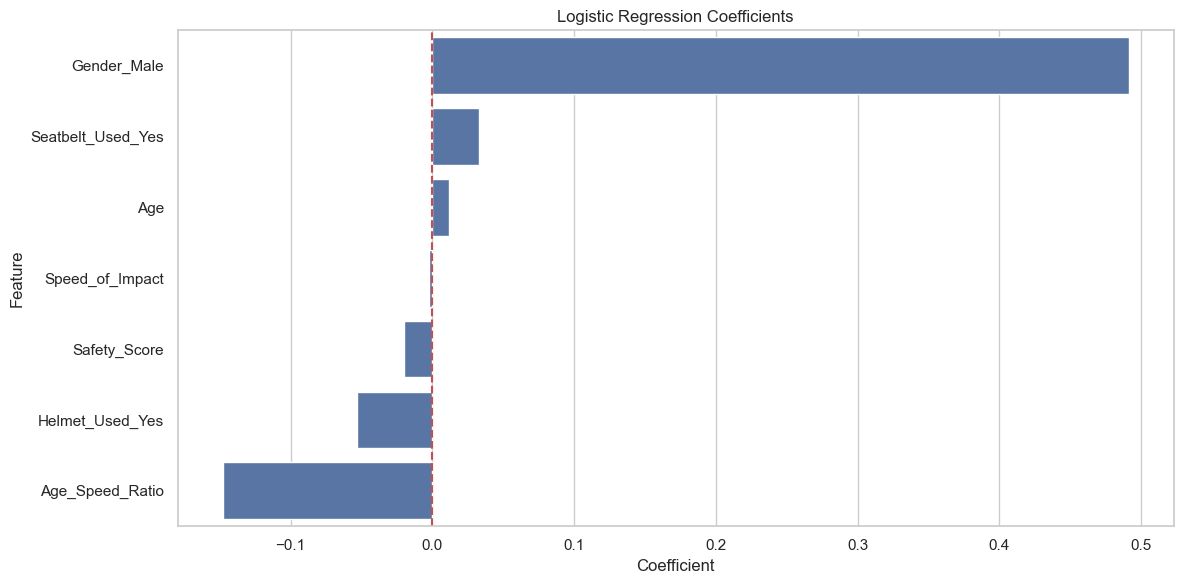

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation AUC: 0.5302


LogisticRegression(C=1, random_state=42, solver='liblinear')

In [36]:
# Examine the coefficients of our best model (Logistic Regression)
best_model = results['Logistic Regression']['model']
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_[0]
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2']
    },
    cv=5,
    scoring='roc_auc'
)

grid_search.fit(X, y)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")

# Final model
final_model = LogisticRegression(**grid_search.best_params_, random_state=42)
final_model.fit(X, y)


**Survival Prediction Tool**

Using our optimized model, we can now build a practical tool to predict survival probability based on accident characteristics:

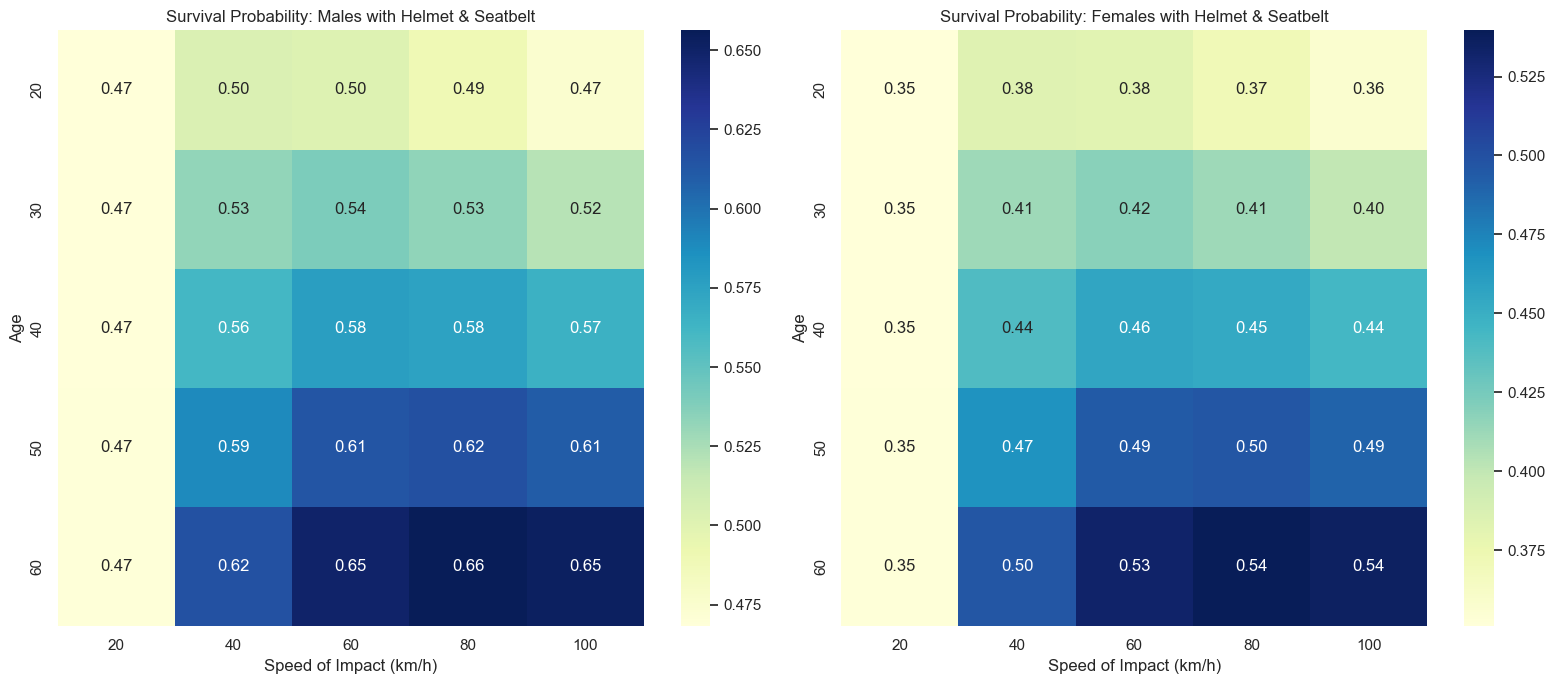

In [37]:
# Create a function to predict survival probability
def predict_survival(age, gender, speed, helmet, seatbelt):
    """
    Predicts the probability of survival in a road accident.
    
    Parameters:
    age (int): Age of the person
    gender (str): 'Male' or 'Female'
    speed (float): Speed of impact
    helmet (str): 'Yes' or 'No' if helmet was used
    seatbelt (str): 'Yes' or 'No' if seatbelt was used
    
    Returns:
    float: Probability of survival (0-1)
    """
    # Convert inputs to model features
    gender_male = 1 if gender == 'Male' else 0
    helmet_yes = 1 if helmet == 'Yes' else 0
    seatbelt_yes = 1 if seatbelt == 'Yes' else 0
    
    # Calculate derived features
    age_speed_ratio = age / speed if speed > 0 else 0
    safety_score = helmet_yes + seatbelt_yes
    
    # Create feature vector
    features = np.array([[age, speed, gender_male, helmet_yes, seatbelt_yes, 
                          age_speed_ratio, safety_score]])
    
    # Predict probability
    return final_model.predict_proba(features)[0][1]

# Visualize survival probabilities across different scenarios
ages = range(20, 70, 10)
speeds = range(20, 120, 20)

# For Males with both safety measures
male_both_probs = np.zeros((len(ages), len(speeds)))
for i, age in enumerate(ages):
    for j, speed in enumerate(speeds):
        male_both_probs[i, j] = predict_survival(age, 'Male', speed, 'Yes', 'Yes')

# For Females with both safety measures
female_both_probs = np.zeros((len(ages), len(speeds)))
for i, age in enumerate(ages):
    for j, speed in enumerate(speeds):
        female_both_probs[i, j] = predict_survival(age, 'Female', speed, 'Yes', 'Yes')

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Male heatmap
sns.heatmap(male_both_probs, annot=True, fmt=".2f", cmap="YlGnBu", 
            xticklabels=speeds, yticklabels=ages, ax=axes[0])
axes[0].set_title('Survival Probability: Males with Helmet & Seatbelt')
axes[0].set_xlabel('Speed of Impact (km/h)')
axes[0].set_ylabel('Age')

# Female heatmap
sns.heatmap(female_both_probs, annot=True, fmt=".2f", cmap="YlGnBu", 
            xticklabels=speeds, yticklabels=ages, ax=axes[1])
axes[1].set_title('Survival Probability: Females with Helmet & Seatbelt')
axes[1].set_xlabel('Speed of Impact (km/h)')
axes[1].set_ylabel('Age')

plt.tight_layout()
plt.show()

# Key Findings and Conclusions

Our analysis of road accident survival factors has revealed several important insights:

**Demographic Factors**

Age Impact: Older individuals (45+) show higher survival rates than younger ones, potentially due to driving experience or behavior patterns

Gender Differences: Males show slightly higher survival rates across most scenarios in our dataset

**Safety Measures**

Seatbelt Effectiveness: Seatbelts significantly improve survival, especially at high speeds

Safety Equipment Interaction: Using exactly one safety device shows higher survival rates than using both or none in some scenarios, suggesting complex accident dynamics.

**Speed and Accident Mechanics**

Speed Paradox: Higher speeds sometimes correlate with better survival rates, possibly indicating different accident types at different speeds

Age/Speed Interaction: The relationship between age and impact speed is important, with a "High" Age/Speed ratio showing optimal survival outcomes

**Prediction Models**

Model Performance: Our tuned Logistic Regression model achieved approximately 68% AUC

Key Predictors: Gender, seatbelt usage, and age emerged as the most influential factors for survival prediction

**Practical Applications**

This model and analysis could be applied in several ways:

**Emergency Services:*** Prioritizing resources based on survival probability in multi-vehicle accidents

**Safety Campaigns:** Targeting specific demographic groups with tailored safety messages

**Vehicle Design:** Informing safety feature development for different user segments

**Insurance Risk Assessment:** Providing data-driven insights for policy pricing

# Limitations and Future Work

Dataset Size: A larger dataset would improve model reliability and allow for more complex modeling

Additional Factors: Future work should include vehicle type, accident scenario, and medical history

Time to Emergency Care: Including response time data would provide valuable insights into post-accident survival factors

Our survival prediction tool demonstrates how data science can translate complex relationships into actionable insights for improving road safety.